### Initial package imports

In [29]:
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt

## Initial files being read in and dataset creation

In [30]:
pd.set_option('display.float_format', '{:.6f}'.format)
# Read the data
main_df = pd.read_csv('Data/Cleaned_Indices_Assignment1.csv', sep=';')

# Read the interest rate data
#interest_rate_df = pd.read_csv('Data/ECB_Rates_2012_to_2022.csv', sep=';')
interest_rate_bond_df = pd.read_csv('Data/ECB_Data_10yr_Treasury_bond.csv', sep=',')

# Convert date columns to datetime format for proper merging
main_df['Date'] = pd.to_datetime(main_df['Date'], format='%d-%m-%Y')
#interest_rate_df['Date'] = pd.to_datetime(interest_rate_df['Date'], format='%d-%m-%Y')
#gov_bond_investment_df['Date'] = pd.to_datetime(gov_bond_investment_df['Date'], format='%Y-%m-%d')
interest_rate_bond_df['Date'] = pd.to_datetime(interest_rate_bond_df['Date'], format='%Y-%m-%d')

# Merge the dataframes on the Date column
main_df = pd.merge(main_df, interest_rate_bond_df, on='Date', how='left')
#main_df = pd.merge(main_df, gov_bond_investment_df, on='Date', how='left')

# Remove rows where the bond does not have a yield curve spot rate (Market closed?)
main_df = main_df.dropna(axis=0, subset=['Yield curve spot rate, 10-year maturity - Government bond'])

# Filter the dataframe to start from 2012-01-04
main_df = main_df[main_df['Date'] >= '2012-01-04']
main_df = main_df.reset_index(drop=True)

### government bond column

In [31]:
	
# Add a column for the interest bond value per day
days_per_annum = 365
interest_bond = 1500000

# Initialize the arrays with appropriate lengths matching the DataFrame
interest_bond_vector = np.zeros(len(main_df))
interest_bond_profit_vector = np.zeros(len(main_df))
interest_bond_loss_vector = np.zeros(len(main_df))
daily_rates = np.zeros(len(main_df))

# Set initial value
interest_bond_vector[0] = interest_bond


# Calculate bond values day by day based on the daily yield rate
for i in range(len(main_df)):
    # Adding 1.5% to account for the credit risk spread
    daily_rate = (((main_df['Yield curve spot rate, 10-year maturity - Government bond'].iloc[i] + 1.5) / (days_per_annum)) * (7/5)) / 100
    daily_rates[i] = daily_rate
    
    if i > 0:
        previous_value = interest_bond_vector[i-1]
        current_value = previous_value * (1 + daily_rate)
        interest_bond_vector[i] = current_value
        
        # Calculate change, profit/loss and return
        change = current_value - previous_value
        interest_bond_profit_vector[i] = change
        interest_bond_loss_vector[i] = -change

# Add vectors to the dataframe
main_df['Interest_Bond'] = interest_bond_vector
main_df['Interest_Bond_Profit'] = interest_bond_profit_vector
main_df['Interest_Bond_Loss'] = interest_bond_loss_vector
main_df['Interest_Bond_daily_rate'] = daily_rates




## Portfolio details

### details

#### Instruments:
- **S&P500**
- **DAX40**
- **NIKKEI**
- **EU Government Bond (10-year maturity, AAA-rated)**

#### Invested amount:
- **10,000,000 EURO**

#### Period:
- **01/01/2012 - 31/12/2022**

#### Weights:
- **S&P500**: 0.4  
- **DAX40**: 0.3  
- **NIKKEI**: 0.15  
- **EU Government Bond**: 0.15  

#### Measures:
- **Value at Risk (VaR)**: 1, 5, 10 days  
- **Expected Shortfall (ES)**  



### weights and currency correction


In [32]:
# initial investment 
weights = {
    'S&P500': 0.4,
    'DAX40': 0.3,
    'NIKKEI': 0.15,
    'EU-BOND': 0.15,
}

starting_investment = 10000000  # 10 million euros
starting_date = '2012-01-04'

# Filter the main_df for the starting date
starting_row = main_df[main_df['Date'] == starting_date]

# Extract the exchange rates for the starting date
usd_to_eur = float(starting_row['USD/EUR'].iloc[0])
jpy_to_eur = float(starting_row['JPY/EUR'].iloc[0])

# Calculate the invested amounts
invested_amount_SP500 = starting_investment * weights['S&P500'] / usd_to_eur
invested_amount_DAX40 = starting_investment * weights['DAX40']
invested_amount_NIKKEI = starting_investment * weights['NIKKEI'] / jpy_to_eur
invested_amount_EU_BOND = starting_investment * weights['EU-BOND']

invested_amounts = [
    invested_amount_SP500, #in USD
    invested_amount_DAX40, #in EUR
    invested_amount_NIKKEI, #in JPY
    invested_amount_EU_BOND #in EUR
]

print(invested_amounts)

[5177993.527508091, 3000000.0, 148957298.90764648, 1500000.0]


### Returns Portfolio 

In [33]:
# Create columns to track investments for each asset
# Initialize the first day with the initial invested amounts
main_df.loc[0, 'SP500_Investment'] = invested_amount_SP500
main_df.loc[0, 'DAX40_Investment'] = invested_amount_DAX40
main_df.loc[0, 'NIKKEI_Investment'] = invested_amount_NIKKEI
main_df.loc[0, 'EU_BOND_Investment'] = invested_amount_EU_BOND

# Calculate daily investment values for subsequent days
# This uses cumulative returns to track the value growth
for i in range(1, len(main_df)):
    # S&P 500 in USD
    main_df.loc[i, 'SP500_Investment'] = main_df.loc[i-1, 'SP500_Investment'] * (1 + main_df.loc[i, 'C_S&P500_Returns'])
    
    # DAX 40 in EUR
    main_df.loc[i, 'DAX40_Investment'] = main_df.loc[i-1, 'DAX40_Investment'] * (1 + main_df.loc[i, 'C_Dax40_Returns'])
    
    # NIKKEI in JPY
    main_df.loc[i, 'NIKKEI_Investment'] = main_df.loc[i-1, 'NIKKEI_Investment'] * (1 + main_df.loc[i, 'C_Nikkei_Returns'])
    
# EU Government Bond value is already calculated in the Interest_Bond column
main_df['EU_BOND_Investment'] = main_df['Interest_Bond']

In [6]:
main_df

,Date,S&P500_Closing,Dax40_Closing,Nikkei_Closing,U_S&P500_Returns,U_Dax40_Returns,U_Nikkei_Returns,U_S&P500_Loss,U_Dax40_Loss,U_Nikkei_Loss,...,TIME PERIOD,"Yield curve spot rate, 10-year maturity - Government bond",Interest_Bond,Interest_Bond_Profit,Interest_Bond_Loss,Interest_Bond_daily_rate,SP500_Investment,DAX40_Investment,NIKKEI_Investment,EU_BOND_Investment
0,2012-01-04,1277.300000,6111.550000,8560.110000,NaN,NaN,NaN,NaN,NaN,NaN,...,04 Jan 2012,2.776691,1500000.000000,0.000000,0.000000,0.000164,5177993.527508,3000000.000000,148957298.907646,1500000.000000
1,2012-01-05,1281.060000,6095.990000,8488.710000,0.002939,-0.002549,-0.008376,-3.760000,15.560000,71.400000,...,05 Jan 2012,2.784807,1500246.523142,246.523142,-246.523142,0.000164,5189897.180583,2992352.262000,148944667.328699,1500246.523142
2,2012-01-06,1277.810000,6057.920000,8390.350000,-0.002540,-0.006265,-0.011655,3.250000,38.070000,98.360000,...,06 Jan 2012,2.788371,1500493.291886,246.768744,-246.768744,0.000164,5179533.786296,2973606.159562,148926943.509066,1500493.291886
3,2012-01-09,1280.700000,6017.230000,8390.350000,0.002259,-0.006739,0.000000,-2.890000,40.690000,0.000000,...,09 Jan 2012,2.757489,1500738.323863,245.031977,-245.031977,0.000163,5188699.359796,2953565.582481,148926943.509066,1500738.323863
4,2012-01-10,1292.080000,6162.980000,8422.260000,0.008847,0.023933,0.003796,-11.380000,-145.750000,-31.910000,...,10 Jan 2012,2.746027,1500982.736072,244.412209,-244.412209,0.000163,5224622.209432,3024254.466714,148932706.981779,1500982.736072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2800,2022-12-23,3844.820000,13940.930000,26235.250000,0.005851,0.001929,-0.010338,-22.430000,-26.860000,272.620000,...,23 Dec 2022,2.464312,1898481.681703,288.631268,-288.631268,0.000152,11203387.897754,5587239.551284,150353000.311487,1898481.681703
2801,2022-12-27,3829.250000,13995.100000,26447.870000,-0.004058,0.003878,0.001589,15.570000,-54.170000,-42.000000,...,27 Dec 2022,2.501054,1898773.032356,291.350653,-291.350653,0.000153,11160667.822429,5608907.709937,150354684.265090,1898773.032356
2802,2022-12-28,3783.220000,13925.600000,26340.500000,-0.012093,-0.004978,-0.004068,46.030000,69.500000,107.370000,...,28 Dec 2022,2.522043,1899065.956342,292.923986,-292.923986,0.000154,11033498.028193,5580984.351838,150350399.156589,1899065.956342
2803,2022-12-29,3849.280000,14071.720000,26093.670000,0.017311,0.010438,-0.009415,-66.060000,-146.120000,246.830000,...,29 Dec 2022,2.526705,1899359.265102,293.308760,-293.308760,0.000154,11212633.819784,5639239.989196,150340415.890085,1899359.265102


## Methods input values 

### time window

### Expected returns (daily)

In [34]:
def calculate_expected_daily_returns(time_window, current_date):
    expected_returns = {
        'Date': current_date,
        'SP500_Mean_Return': time_window['C_S&P500_Returns'].mean(),
        'DAX40_Mean_Return': time_window['C_Dax40_Returns'].mean(),
        'NIKKEI_Mean_Return': time_window['C_Nikkei_Returns'].mean(),
        'EU_Bond_Mean_Return': time_window['Interest_Bond_daily_rate'].mean(),
        'Portfolio_Mean_Return': (
            weights['S&P500'] * time_window['C_S&P500_Returns'].mean() +
            weights['DAX40'] * time_window['C_Dax40_Returns'].mean() +
            weights['NIKKEI'] * time_window['C_Nikkei_Returns'].mean() +
            weights['EU-BOND'] * time_window['Interest_Bond_daily_rate'].mean()
        )
    }
    return expected_returns

In [35]:
# Calculate total portfolio value in EUR for each day
main_df['Portfolio_Value_EUR'] = (
    main_df['SP500_Investment'].fillna(0) * main_df['USD/EUR'] +
    main_df['DAX40_Investment'].fillna(0) +
    main_df['NIKKEI_Investment'].fillna(0) * main_df['JPY/EUR'] +
    main_df['EU_BOND_Investment'].fillna(0)
)

# First day should be the initial investment amount
main_df.loc[0, 'Portfolio_Value_EUR'] = starting_investment

# Calculate the daily change in portfolio value (profit/loss)
main_df['Portfolio_Change_EUR'] = main_df['Portfolio_Value_EUR'].diff()
main_df.loc[0, 'Portfolio_Change_EUR'] = 0.0  # Set the first day's change to 0

# Portfolio loss is the negative of the daily change
main_df['Portfolio_loss'] = -main_df['Portfolio_Change_EUR']

# Set the first day's loss to 0 (there's no previous day to compare with)
main_df.loc[0, 'Portfolio_loss'] = 0.0

# Display the relevant columns to verify
display(main_df[['Date', 'SP500_Investment', 'DAX40_Investment', 'NIKKEI_Investment', 
                'EU_BOND_Investment', 'USD/EUR', 'JPY/EUR', 'Portfolio_Value_EUR', 
                'Portfolio_Change_EUR', 'Portfolio_loss']].head())

In [36]:
loss_values = main_df['Portfolio_loss'].values

# Calculate and print the minimum, maximum, and mean of portfolio loss values
min_loss = np.nanmin(loss_values)
max_loss = np.nanmax(loss_values)
mean_loss = np.nanmean(loss_values)

print(f"Portfolio Loss Statistics:")
print(f"Minimum Loss: {min_loss:.4f}")
print(f"Maximum Loss: {max_loss:.4f}")
print(f"Mean Loss: {mean_loss:.4f}")

# Also print the number of valid loss values (non-NaN)
valid_count = np.sum(~np.isnan(loss_values))
print(f"Number of valid loss values: {valid_count} out of {len(loss_values)}")

Portfolio Loss Statistics:
Minimum Loss: -850226.1277
Maximum Loss: 1342732.3566
Mean Loss: -3159.9667
Number of valid loss values: 2803 out of 2805


In [37]:
def calculate_daily_loss_variables(time_window, current_date):
    # Calculate the mean and standard deviation of portfolio loss from the time windows
    loss_dict = {
        "Date": current_date,
        "Portfolio_mean_loss": np.nanmean(time_window['Portfolio_loss']),
        "Portfolio_std_loss": np.nanstd(time_window['Portfolio_loss'])
    }
    return loss_dict

### Covariance matrix --> action make into method with variable time window

### Portfolio variance

In [38]:
def calculate_variance_return(window, current_date, weights):
    """
    Calculate the variance returns for each index and the portfolio variance and volatility.
    """
    variance_return = {
        'Date': current_date,
        'SP500_Var_Return': window['C_S&P500_Returns'].var(),
        'DAX40_Var_Return': window['C_Dax40_Returns'].var(),
        'NIKKEI_Var_Return': window['C_Nikkei_Returns'].var(),
        'EU_Bond_Var_Return': window['Interest_Bond_daily_rate'].var()
    }

    weights = np.array([weights['S&P500'], weights['DAX40'], weights['NIKKEI'], weights['EU-BOND']])

    # Calculate the covariance matrix for the returns in the window
    covariance_matrix = window[['C_S&P500_Returns', 'C_Dax40_Returns', 'C_Nikkei_Returns', 'Interest_Bond_daily_rate']].cov()

    # Calculate the portfolio variance using the covariance matrix and weights
    portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix.values, weights))
    portfolio_volatility = np.sqrt(portfolio_variance)

    # Add portfolio variance and volatility to the variance_return dictionary
    variance_return['Portfolio_Variance'] = portfolio_variance
    variance_return['Portfolio_Volatility'] = portfolio_volatility

    return variance_return

# Value at Risk (VaR)

In [64]:
def VaR(alpha, r= 0, s= 1, df= 0):
    """
    Purpose:
        Get the VaR of the normal model

    Inputs:
        alpha   double, level
        r       double, expected return
        s       double, volatility
        df      (optional) double, degrees of freedom for student-t

    Return value:
        dVaR    double, VaR
    """
    if (df == 0):
        dVaR0= st.norm.ppf(alpha)
        dVaR = r + s*dVaR0
    else:
        dVaR0= st.t.ppf(alpha, df= df)

        dS2t= df/(df-2)

        c = s / np.sqrt(dS2t)
        dVaR= r + c*dVaR0
    return dVaR

# Expected Shortfall (ES) 

In [65]:
def ES(alpha, r= 0, s= 1, df= 0):
    """
    Purpose:
        Get the ES of the normal/student model

    Inputs:
        alpha   double, level
        r       double, expected return
        s       double, volatility
        df      (optional, default= 0/normal) double, df

    Return value:
        dES     double, ES
    """
    if (df == 0):
        dVaR0= st.norm.ppf(alpha)
        dES0= st.norm.pdf(dVaR0) / (1-alpha)
        dES= r + s*dES0
    else:
        dVaR0= st.t.ppf(alpha, df= df)
        dES0= st.t.pdf(dVaR0, df= df)*((df + dVaR0**2)/(df-1)) / (1-alpha)

        dS2t= df/(df-2)
        c= s / np.sqrt(dS2t)
        dES= r + c*dES0
    return dES

## performing different methods

write method for variance covariance where the sample period is an input parameter alongside other parameters that are needed for the calculation

## 1. var/cov multivar normal dist & T-distribution

4 code blocks with functions to calculate components of Var/cov method, 1 code block with for loop to iterate through set window for daily VaR and ES

In [71]:
def calculate_ewma_volatility(loss_series, lambda_=0.94):
    weights = (1 - lambda_) * (lambda_ ** np.arange(len(loss_series)-1, -1, -1))
    weighted_squared_losses = weights * (loss_series ** 2)
    ewma_variance = weighted_squared_losses.sum()
    return np.sqrt(ewma_variance)


In [75]:
def calculate_ewma_vol_series(loss_series, lambda_=0.94):
    ewma_var = [loss_series.iloc[0] ** 2]  # Seed with squared first value
    for t in range(1, len(loss_series)):
        prev_var = ewma_var[-1]
        new_var = lambda_ * prev_var + (1 - lambda_) * (loss_series.iloc[t - 1] ** 2)
        ewma_var.append(new_var)
    return pd.Series(np.sqrt(ewma_var), index=loss_series.index)


In [84]:
def main():
    # Initialize lists to store results
    mean_losses = []
    portfolio_std_losses = []
    ewma_vol_94 = []  # For λ = 0.94
    ewma_vol_97 = []  # For λ = 0.97
    VaR_results = []
    ES_results = []

    time_window = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]
    vAlpha = np.array([0.95, 0.99])
    sample_size = 500
    degrees_of_freedom = [0, 3, 4, 5, 6]

    fhs_results = []


    for i in range(sample_size, len(time_window)):
        window = time_window.iloc[i - sample_size:i]
        current_date = time_window.iloc[i]['Date']
        
        loss_stats = calculate_daily_loss_variables(window, current_date)
        mean_loss = loss_stats["Portfolio_mean_loss"]
        std_loss = loss_stats["Portfolio_std_loss"]
        
        # Calculate EWMA volatilities for both lambda values
        ewma_94 = calculate_ewma_volatility(window['Portfolio_loss'], lambda_=0.94)
        ewma_97 = calculate_ewma_volatility(window['Portfolio_loss'], lambda_=0.97)

        # --- Filtered Historical Simulation (FHS) using EWMA filtered losses ---
        factors = ['C_S&P500_Loss', 'C_Dax40_Loss', 'C_Nikkei_Loss', 'Interest_Bond_Loss']
        filtered_losses = []

        for factor in factors:
            series = window[factor]
            vol_series = calculate_ewma_vol_series(series, lambda_=0.94)
            current_vol = vol_series.iloc[-1]

            normalized = series / vol_series
            normalized = normalized.replace([np.inf, -np.inf], 0).fillna(0)

            filtered = normalized * current_vol
            filtered_losses.append(filtered)

        # Combine into filtered portfolio loss
        filtered_portfolio_loss = np.sum(filtered_losses, axis=0)

        # Calculate FHS VaR and ES
        FHS_VaR_95 = np.percentile(filtered_portfolio_loss, 5)
        FHS_VaR_99 = np.percentile(filtered_portfolio_loss, 1)
        FHS_ES_95 = filtered_portfolio_loss[filtered_portfolio_loss <= FHS_VaR_95].mean()
        FHS_ES_99 = filtered_portfolio_loss[filtered_portfolio_loss <= FHS_VaR_99].mean()

        # Store results
        fhs_results.append({
            'Date': current_date,
            'FHS_VaR_95': FHS_VaR_95,
            'FHS_VaR_99': FHS_VaR_99,
            'FHS_ES_95': FHS_ES_95,
            'FHS_ES_99': FHS_ES_99
        })

        
        # Append everything
        mean_losses.append(mean_loss)
        portfolio_std_losses.append(std_loss)
        ewma_vol_94.append(ewma_94)
        ewma_vol_97.append(ewma_97)
        
        var_row = {'Date': current_date}
        es_row = {'Date': current_date}
        
        for df in degrees_of_freedom:
            current_var = VaR(vAlpha, mean_loss, std_loss, df)
            current_es = ES(vAlpha, mean_loss, std_loss, df)
            
            var_key = f"VaR {'Normal' if df == 0 else f'T{df}'}"
            es_key = f"ES {'Normal' if df == 0 else f'T{df}'}"
            var_row[var_key] = current_var
            es_row[es_key] = current_es

        # Historical simulation
        # Extract the portfolio loss values from the window
        historical_losses = window['Portfolio_loss'].dropna()  # Remove NaN values directly
        
        # Sort the losses in ascending order
        sorted_losses = np.sort(historical_losses)

        # Calculate VaR for alpha levels
        var_95 = np.percentile(sorted_losses, 95) 
        var_99 = np.percentile(sorted_losses, 99)  

        # Calculate ES
        es_95 = sorted_losses[sorted_losses >= var_95].mean()  # Mean of losses below VaR 95
        es_99 = sorted_losses[sorted_losses >= var_99].mean()  # Mean of losses below VaR 99

        # Add to the row dictionaries
        var_row['VaR Historical'] = [var_95, var_99]
        es_row['ES Historical'] = [es_95, es_99]
        
        VaR_results.append(var_row)
        ES_results.append(es_row)

    # Final DataFrames
    mean_losses_df = pd.DataFrame(mean_losses, columns=['Mean_Loss'])
    portfolio_std_losses_df = pd.DataFrame(portfolio_std_losses, columns=['Std_Loss'])
    ewma_94_df = pd.DataFrame(ewma_vol_94, columns=['EWMA_0.94'])
    ewma_97_df = pd.DataFrame(ewma_vol_97, columns=['EWMA_0.97'])
    var_results_df = pd.DataFrame(VaR_results)
    es_results_df = pd.DataFrame(ES_results)
    fhs_df = pd.DataFrame(fhs_results)


    return mean_losses_df, portfolio_std_losses_df, ewma_94_df, ewma_97_df, var_results_df, es_results_df, fhs_df 


/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/673492452.py:51: RuntimeWarning: Mean of empty slice.
  FHS_ES_95 = filtered_portfolio_loss[filtered_portfolio_loss <= FHS_VaR_95].mean()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/8l/w3h2llvd3nd7712wt9bl0vkm0000gn/T/ipykernel_50036/673492452.py:52: RuntimeWarning: Mean of empty slice.
  FHS_ES_99 = filtered_portfolio_loss[filtered_portfolio_loss <= FHS_VaR_99].mean()


Mean Loss Results Head:


,Mean_Loss
0,-192.824238
1,-192.346281
2,-192.259451
3,-192.319473
4,-192.027996



Portfolio Std Loss Results Head:


,Std_Loss
0,118.756581
1,119.654655
2,119.656496
3,119.677994
4,119.997366



FHS Results Head:


,Date,FHS_VaR_95,FHS_VaR_99,FHS_ES_95,FHS_ES_99
0,2015-12-03,NaN,NaN,NaN,NaN
1,2015-12-04,382.290918,495.179825,466.460397,613.023522
2,2015-12-07,436.724060,577.921030,527.729499,663.844445
3,2015-12-08,430.184267,570.693385,520.129741,652.007013
4,2015-12-09,418.018378,538.287576,503.539788,623.906461



VaR Results Head:


,EWMA_0.94
0,204.933907
1,210.608780
2,207.315729
3,211.233658
4,205.851081



ES Results Head:


,EWMA_0.97
0,216.293872
1,218.674555
2,216.856087
3,218.460714
4,215.660440



EWMA Volatility Results Head:


,Date,VaR Normal,VaR T3,VaR T4,VaR T5,VaR T6
0,2015-12-03,"[2.5129557625034806, 83.44488271228627]","[-31.467887853444324, 118.50516774627911]","[-13.805422635742161, 121.82036330433138]","[-7.463056488013734, 116.71046505557118]","[-4.405039270274443, 111.90253798950678]"
1,2015-12-04,"[4.468112381100269, 86.01207150668895]","[-29.76970484758371, 121.33749322211835]","[-11.973670624117062, 124.67775931076451]","[-5.583341548784574, 119.5292184365139]","[-2.5021986623263217, 114.68493234411389]"
2,2015-12-07,"[4.557970530093883, 86.10318416601493]","[-29.680373429152723, 121.42914934422205]","[-11.884065423188304, 124.76946682108095]","[-5.493638036050271, 119.62084673927419]","[-2.412447747851587, 114.77648612011555]"
3,2015-12-08,"[4.533309711388881, 86.09317406856707]","[-29.711185638126835, 121.42548604318188]","[-11.911680280210362, 124.76640365410236]","[-5.520104764737255, 119.61685855175404]","[-2.4383608982469696, 114.7716275764588]"
4,2015-12-09,"[5.350107627536346, 87.12762243948526]","[-28.985772498608924, 122.55422213551782]","[-11.138767424178951, 125.90405531101283]","[-4.730135365900026, 120.74076814518486]","[-1.6401675652564052, 115.88260719834597]"


,Date,ES Normal,ES T3,ES T4,ES T5,ES T6
0,2015-12-03,"[52.13648350391358, 123.68749151202982]","[72.81159896098345, 287.3360887173585]","[76.13226886170636, 245.56692736832358]","[73.03425106672685, 216.74782534497658]","[70.02074483678322, 198.1871576985208]"
1,2015-12-04,"[54.46690853387028, 126.55900731744131]","[75.29837558635043, 291.4451656533397]","[78.64415741633374, 249.36013303241603]","[75.52271145594162, 220.32309207716807]","[72.48641616308757, 201.62206294134458]"
2,2015-12-07,"[54.5575358876836, 126.65074376975528]","[75.38932342117712, 291.53943879128315]","[78.73515672422994, 249.45375871457216]","[75.61366274205605, 220.41627103993156]","[72.5773207374178, 201.71495419874603]"
3,2015-12-08,"[54.54185817984887, 126.648018600103]","[75.37738843101812, 291.56633814772516]","[78.72382285912664, 249.47309679868147]","[75.60176805754719, 220.43039213926687]","[72.5648805322295, 201.72571534882178]"
4,2015-12-09,"[55.492108786267124, 127.79069153006157]","[76.38324068256293, 293.1491117023288]","[79.73860539741088, 250.94354043225593]","[76.60821908801518, 221.82333248213934]","[73.56322733206662, 203.0687404369072]"


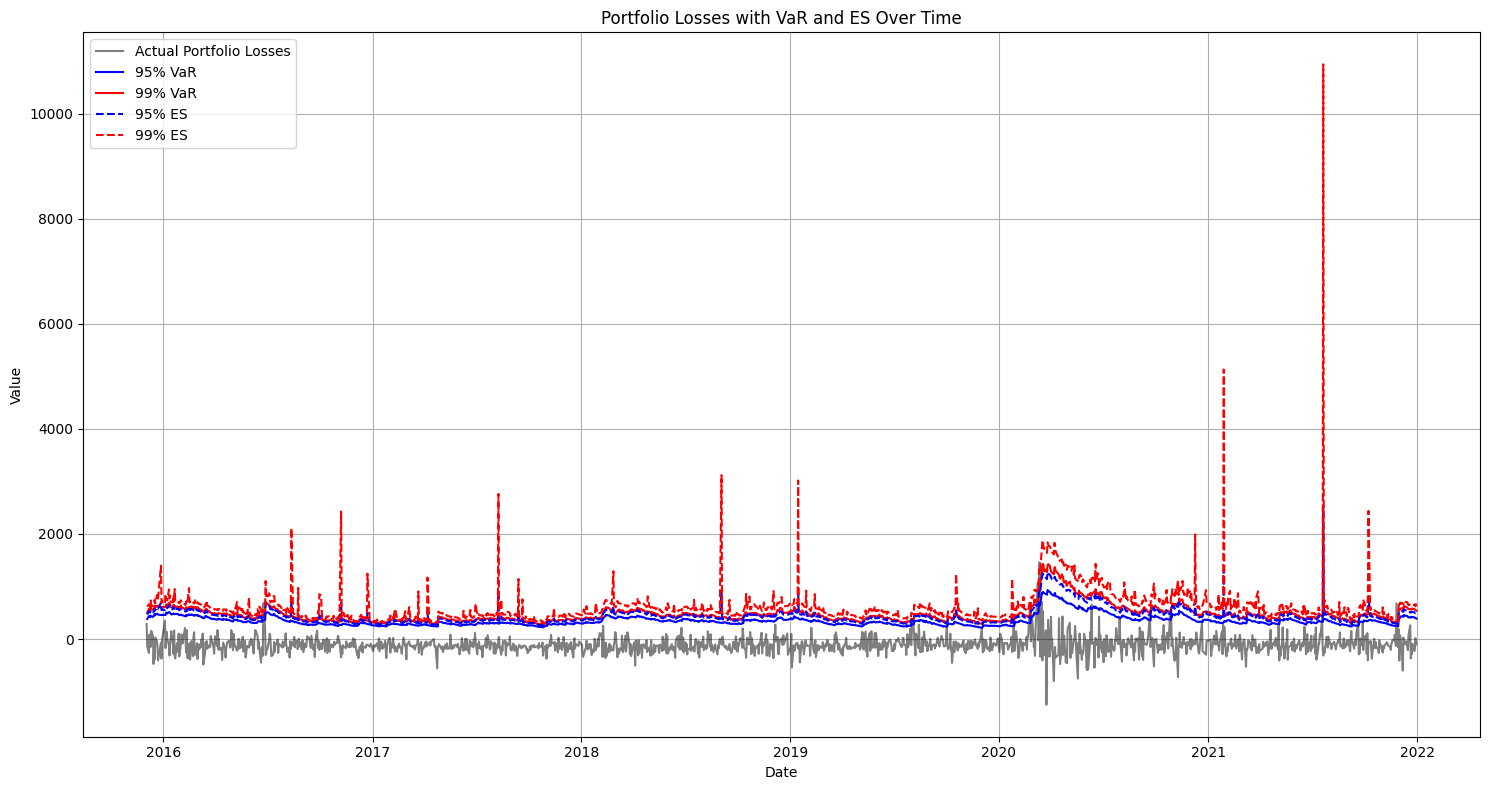

In [85]:
# Unpack the returned DataFrames
mean_loss_df, portfolio_std_losses_df, var_results_df, es_results_df, ewma_94_df, ewma_97_df, fhs_df  = main()

fhs_df[['FHS_VaR_95', 'FHS_VaR_99', 'FHS_ES_95', 'FHS_ES_99']] = fhs_df[
    ['FHS_VaR_95', 'FHS_VaR_99', 'FHS_ES_95', 'FHS_ES_99']].abs()


# Display the results

print("Mean Loss Results Head:")
display(mean_loss_df.head())
print("\nPortfolio Std Loss Results Head:")
display(portfolio_std_losses_df.head())
print("\nFHS Results Head:")
display(fhs_df.head())
print("\nVaR Results Head:")
display(var_results_df.head())
print("\nES Results Head:")
display(es_results_df.head())
print("\nEWMA Volatility Results Head:")
display(ewma_94_df.head())
display(ewma_97_df.head())

# Extract the actual losses aligned with fhs_df
aligned_losses = main_df.loc[main_df['Date'].isin(fhs_df['Date']), 'Portfolio_loss'].values

# Create a figure for comparing VaR, ES and actual portfolio losses
fig, ax = plt.subplots(figsize=(15, 8))

# Plot actual portfolio losses
ax.plot(fhs_df['Date'], aligned_losses, label='Actual Portfolio Losses', color='black', alpha=0.5)


# Plot VaR values
ax.plot(fhs_df['Date'], fhs_df['FHS_VaR_95'], label='95% VaR', color='blue')
ax.plot(fhs_df['Date'], fhs_df['FHS_VaR_99'], label='99% VaR', color='red')

# Plot ES values
ax.plot(fhs_df['Date'], fhs_df['FHS_ES_95'], label='95% ES', color='blue', linestyle='--')
ax.plot(fhs_df['Date'], fhs_df['FHS_ES_99'], label='99% ES', color='red', linestyle='--')

# Customize the plot
ax.set_title('Portfolio Losses with VaR and ES Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

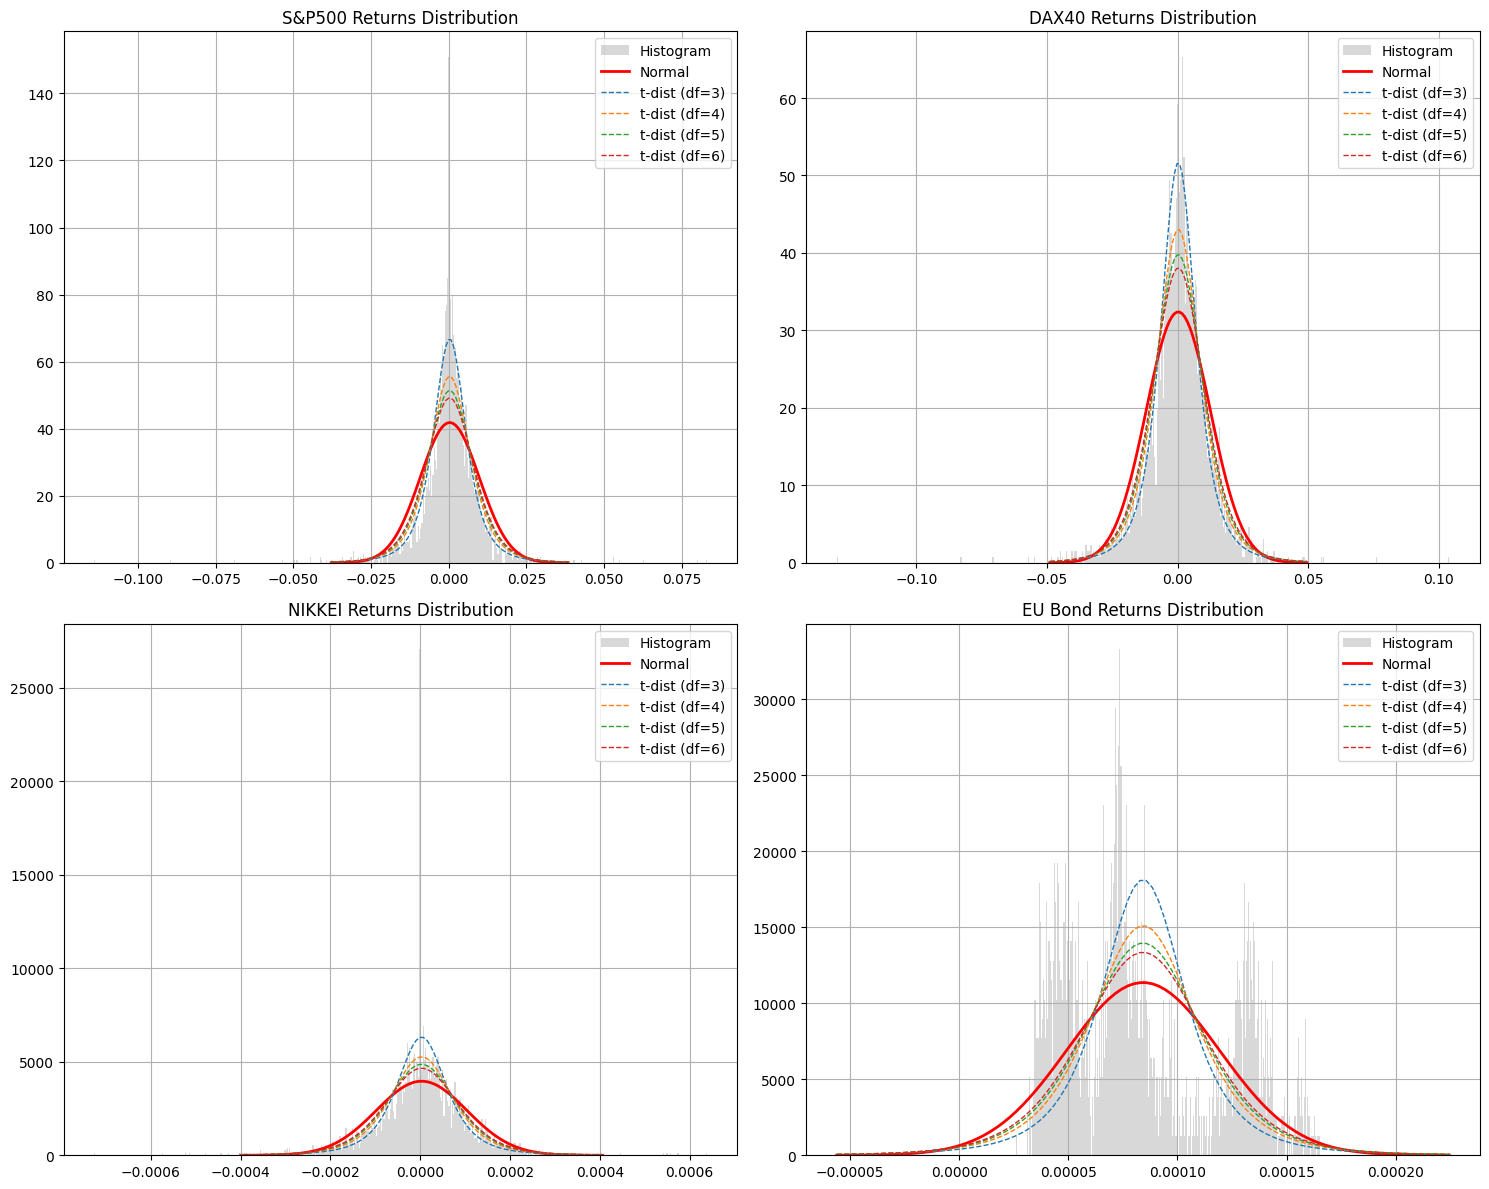

In [43]:
# Create subplots for all indices
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# S&P 500
sp500_returns = main_df['C_S&P500_Returns'].dropna()
mu_sp500 = sp500_returns.mean()
sigma_sp500 = sp500_returns.std()
x_sp500 = np.linspace(mu_sp500 - 4*sigma_sp500, mu_sp500 + 4*sigma_sp500, 100)
ax1.hist(sp500_returns, bins=500, density=True, alpha=0.3, color='grey', label='Histogram')
ax1.plot(x_sp500, st.norm.pdf(x_sp500, mu_sp500, sigma_sp500), 'r-', lw=2, label='Normal')
# Add t-distributions
for df in [3, 4, 5, 6]:
    s = sigma_sp500 / np.sqrt(df/(df-2))
    ax1.plot(x_sp500, st.t.pdf((x_sp500-mu_sp500)/s, df)/s, '--', lw=1, label=f't-dist (df={df})')
ax1.set_title('S&P500 Returns Distribution')
ax1.legend()
ax1.grid(True)

# DAX40
dax_returns = main_df['C_Dax40_Returns'].dropna()
mu_dax = dax_returns.mean()
sigma_dax = dax_returns.std()
x_dax = np.linspace(mu_dax - 4*sigma_dax, mu_dax + 4*sigma_dax, 100)
ax2.hist(dax_returns, bins=500, density=True, alpha=0.3, color='grey', label='Histogram')
ax2.plot(x_dax, st.norm.pdf(x_dax, mu_dax, sigma_dax), 'r-', lw=2, label='Normal')
# Add t-distributions
for df in [3, 4, 5, 6]:
    s = sigma_dax / np.sqrt(df/(df-2))
    ax2.plot(x_dax, st.t.pdf((x_dax-mu_dax)/s, df)/s, '--', lw=1, label=f't-dist (df={df})')
ax2.set_title('DAX40 Returns Distribution')
ax2.legend()
ax2.grid(True)

# NIKKEI
nikkei_returns = main_df['C_Nikkei_Returns'].dropna()
mu_nikkei = nikkei_returns.mean()
sigma_nikkei = nikkei_returns.std()
x_nikkei = np.linspace(mu_nikkei - 4*sigma_nikkei, mu_nikkei + 4*sigma_nikkei, 100)
ax3.hist(nikkei_returns, bins=500, density=True, alpha=0.3, color='grey', label='Histogram')
ax3.plot(x_nikkei, st.norm.pdf(x_nikkei, mu_nikkei, sigma_nikkei), 'r-', lw=2, label='Normal')
# Add t-distributions
for df in [3, 4, 5, 6]:
    s = sigma_nikkei / np.sqrt(df/(df-2))
    ax3.plot(x_nikkei, st.t.pdf((x_nikkei-mu_nikkei)/s, df)/s, '--', lw=1, label=f't-dist (df={df})')
ax3.set_title('NIKKEI Returns Distribution')
ax3.legend()
ax3.grid(True)

# EU Bond
bond_returns = main_df['Interest_Bond_daily_rate'].dropna()
mu_bond = bond_returns.mean()
sigma_bond = bond_returns.std()
x_bond = np.linspace(mu_bond - 4*sigma_bond, mu_bond + 4*sigma_bond, 100)
ax4.hist(bond_returns, bins=500, density=True, alpha=0.3, color='grey', label='Histogram')
ax4.plot(x_bond, st.norm.pdf(x_bond, mu_bond, sigma_bond), 'r-', lw=2, label='Normal')
# Add t-distributions
for df in [3, 4, 5, 6]:
    s = sigma_bond / np.sqrt(df/(df-2))
    ax4.plot(x_bond, st.t.pdf((x_bond-mu_bond)/s, df)/s, '--', lw=1, label=f't-dist (df={df})')
ax4.set_title('EU Bond Returns Distribution')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()

## 2. var/cov multivar on t-dist

## Main method

In [44]:
def main():
    # Magic numbers
    vN = len(main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')])
    P = 50
    dMu = calculate_expected_daily_returns(window, current_date)["Portfolio_Mean_Return"]
    dSy = calculate_variance_return(window, current_date, weights)['Portfolio_Volatility']
    print(f'vN= {vN}, P= {P}, dMu= {dMu}, dSy= {dSy}')
    vAlpha= [.95, .99]
    iDF= 6

    # Initialisation
    vAlpha= np.array(vAlpha)

    # Estimation
    vVaR= VaR(vAlpha, dMu, dSy)
    vVaRt= VaR(vAlpha, dMu, dSy, df= iDF)
    print ('var, vart:', vVaR, vVaRt)

    vES= ES(vAlpha, dMu, dSy)
    vESt= ES(vAlpha, dMu, dSy, df= iDF)
    print ('es, est:', vES, vESt)

    vN= dMu+dSy*st.norm.rvs(size= 10000000)
    print (f'Simulating Norm, mean= {vN.mean()}, std= {vN.std()}')

    dVaRs= np.quantile(vN, .95)
    vI= vN >= dVaRs
    print (f'Sim, var= {dVaRs}, ES= {vN[vI].mean()}')

    dS2t= iDF/(iDF-2)
    dC= dSy / np.sqrt(dS2t)
    vT= dMu+dC*st.t.rvs(df= iDF, size= 10000000)
    print (f'Simulating t({iDF}), mean= {vT.mean()}, std= {vT.std()}')

    dVaRt= np.quantile(vT, .95)
    vI= vT >= dVaRt
    print (f'Sim, vart= {dVaRt}, ES= {vT[vI].mean()}')

    np.quantile(vT, .99)
    VaR(.95, 0, 1)


In [45]:
main()

vN= 2548, P= 50, dMu= 0.0004848880254979274, dSy= 0.004935414884390409
var, vart: [0.00860292 0.01196638] [0.00831542 0.01314905]
es, est: [0.01066523 0.01363883] [0.01140849 0.01673496]
Simulating Norm, mean= 0.0004849686549599822, std= 0.004936424864531182
Sim, var= 0.008599858377072606, ES= 0.010663450377831682
Simulating t(6), mean= 0.0004851780910416411, std= 0.004934298425109874
Sim, vart= 0.00831376491003216, ES= 0.011411828399544143


## Historical simulation

VaR (S&P500) at 95.0% confidence level: 31.027729599999944
ES (S&P500) at 95.0% confidence level: 59.257054484375004


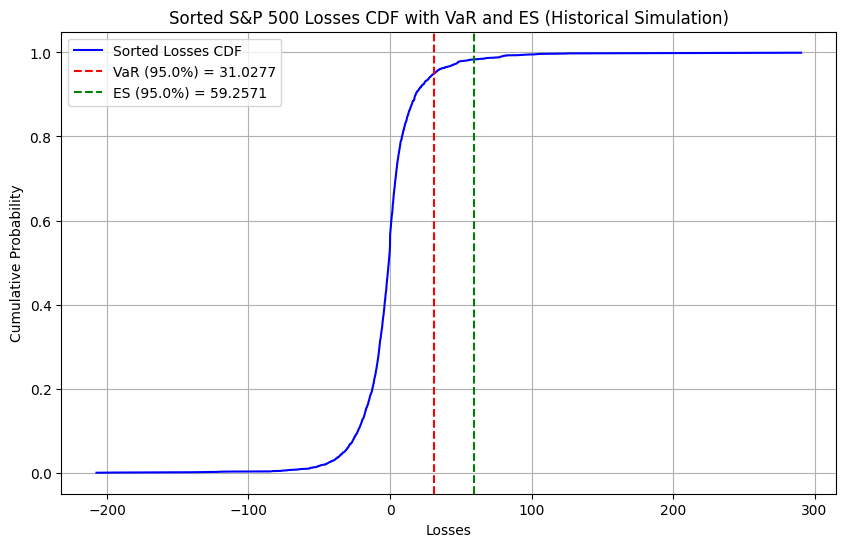

In [46]:
# Define the confidence level
confidence_level = 0.95

# Extract historical losses for S&P500 for the specified period
sp500_losses = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]['C_S&P500_Loss']

# Sort the losses in ascending order (smallest loss first, largest loss last)
sorted_losses = sp500_losses.sort_values()

# Calculate VaR at the specified confidence level
# This finds the value at the threshold separating the worst (1-confidence_level)% losses
VaR_sp500 = sorted_losses.quantile(confidence_level)

# Calculate ES (Expected Shortfall)
# This is the average of the losses that are greater than or equal to the VaR value
tail_sp_losses = sorted_losses[sorted_losses >= VaR_sp500]
ES_sp500 = tail_sp_losses.mean()

print(f"VaR (S&P500) at {confidence_level * 100}% confidence level: {VaR_sp500}")
print(f"ES (S&P500) at {confidence_level * 100}% confidence level: {ES_sp500}")

# Plot the sorted losses (Empirical Cumulative Distribution Function - CDF)
plt.figure(figsize=(10, 6))
# Plotting the empirical CDF: x-axis is loss value, y-axis is cumulative probability
plt.plot(sorted_losses.values, np.linspace(0, 1, len(sorted_losses), endpoint=False), label='Sorted Losses CDF', color='blue')

# Highlight VaR and ES on the graph
# VaR is the loss value at the confidence level percentile
plt.axvline(x=VaR_sp500, color='red', linestyle='--', label=f'VaR ({confidence_level * 100}%) = {VaR_sp500:.4f}')
# ES is the average loss in the tail beyond VaR
plt.axvline(x=ES_sp500, color='green', linestyle='--', label=f'ES ({confidence_level * 100}%) = {ES_sp500:.4f}')

# Add labels, title, and legend
plt.xlabel('Losses')
plt.ylabel('Cumulative Probability') # Changed from 'Probability' to be more precise for CDF
plt.title('Sorted S&P 500 Losses CDF with VaR and ES (Historical Simulation)')
plt.legend()
plt.grid(True) # Changed grid() to grid(True) for clarity
plt.show()

VaR (DAX40) at 95.0% confidence level: 199.3679999999997
ES (DAX40) at 95.0% confidence level: 314.866953125


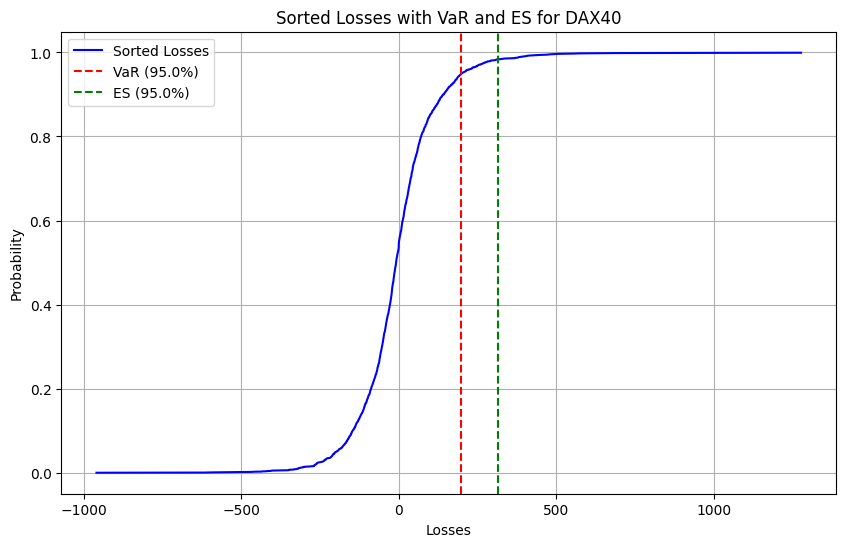

In [47]:
confidence_level = 0.95
# Extract historical losses for DAX40
dax40_losses = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]['C_Dax40_Loss']

# Sort the losses in ascending order
sorted_dax40_losses = dax40_losses.sort_values()

# Calculate VaR at the specified confidence level
# This finds the value at the threshold separating the worst (1-confidence_level)% losses
VaR_dax40 = sorted_dax40_losses.quantile(confidence_level)

# Calculate ES (Expected Shortfall)
# This is the average of the losses that are greater than or equal to the VaR value
tail_dax_losses = sorted_dax40_losses[sorted_dax40_losses >= VaR_dax40]
ES_dax40 = tail_dax_losses.mean()

print(f"VaR (DAX40) at {confidence_level * 100}% confidence level: {VaR_dax40}")
print(f"ES (DAX40) at {confidence_level * 100}% confidence level: {ES_dax40}")

# Plot the sorted losses as a line graph
plt.figure(figsize=(10, 6))
plt.plot(sorted_dax40_losses.values, np.linspace(0, 1, len(sorted_dax40_losses), endpoint=False), label='Sorted Losses', color='blue')

# Highlight VaR and ES on the graph
plt.axvline(x=VaR_dax40, color='red', linestyle='--', label=f'VaR ({confidence_level * 100}%)')
plt.axvline(x=ES_dax40, color='green', linestyle='--', label=f'ES ({confidence_level * 100}%)')

# Add labels, title, and legend
plt.xlabel('Losses')
plt.ylabel('Probability')
plt.title('Sorted Losses with VaR and ES for DAX40')
plt.legend()
plt.grid()
plt.show()

VaR (Nikkei) at 95.0% confidence level: 3.0092212339999986
ES (Nikkei) at 95.0% confidence level: 4.61174921890625


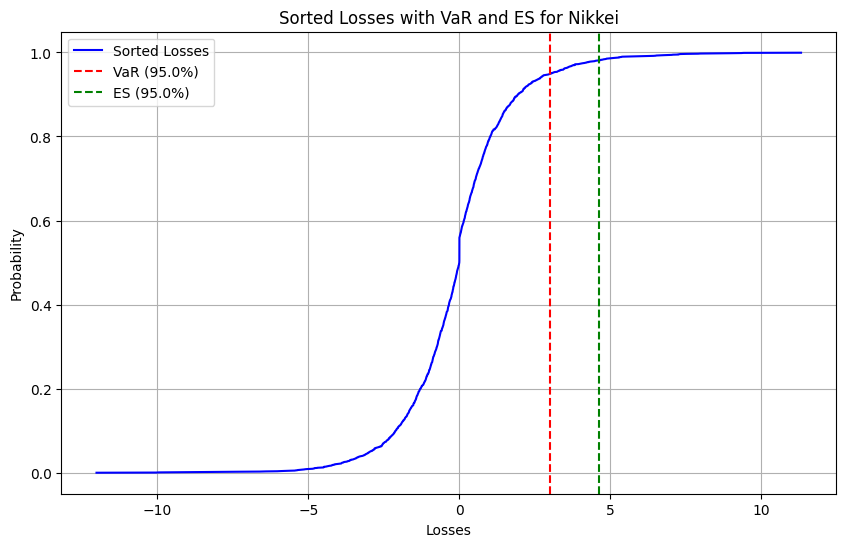

In [48]:
confidence_level = 0.95

# Extract historical losses for Nikkei
nikkei_losses = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]['C_Nikkei_Loss']

# Sort the losses in ascending order
sorted_nikkei_losses = nikkei_losses.sort_values()

# Calculate VaR at the specified confidence level
# This finds the value at the threshold separating the worst (1-confidence_level)% losses
VaR_nikkei = sorted_nikkei_losses.quantile(confidence_level)

# Calculate ES (Expected Shortfall)
# This is the average of the losses that are greater than or equal to the VaR value
tail_nik_losses = sorted_nikkei_losses[sorted_nikkei_losses >= VaR_nikkei]
ES_nikkei = tail_nik_losses.mean()

print(f"VaR (Nikkei) at {confidence_level * 100}% confidence level: {VaR_nikkei}")
print(f"ES (Nikkei) at {confidence_level * 100}% confidence level: {ES_nikkei}")

# Plot the sorted losses as a line graph
plt.figure(figsize=(10, 6))
plt.plot(sorted_nikkei_losses.values, np.linspace(0, 1, len(sorted_nikkei_losses), endpoint=False), label='Sorted Losses', color='blue')

# Highlight VaR and ES on the graph
plt.axvline(x=VaR_nikkei, color='red', linestyle='--', label=f'VaR ({confidence_level * 100}%)')
plt.axvline(x=ES_nikkei, color='green', linestyle='--', label=f'ES ({confidence_level * 100}%)')

# Add labels, title, and legend
plt.xlabel('Losses')
plt.ylabel('Probability')
plt.title('Sorted Losses with VaR and ES for Nikkei')
plt.legend()
plt.grid()
plt.show()

In [59]:
## Backtesting VaR and ES

In this section, we perform backtesting on the calculated Value at Risk (VaR) and Expected Shortfall (ES) measures. Backtesting helps assess the accuracy and reliability of the risk models.

We will:
1.  **Calculate Violations:** Identify the days where the actual portfolio loss exceeded the predicted VaR.
2.  **Compare Actual vs. Expected Violations (VaR):** Group violations by year and compare the observed number of violations against the number expected based on the confidence level (alpha).
3.  **Compare Actual Shortfall vs. Predicted ES (ES):** For the days a violation occurred, compare the average actual loss (shortfall) against the predicted ES, grouped by year.
4.  **Visualize Violations:** Plot the occurrences of violations over time to visually inspect for clustering or patterns.